# Stochastic growth model

We now add randomness to the growth model. We do this by easing the assumption that in the steady state the technology stock is constant. We assume that 

$$A_t = \exp(\eta_t)$$

where 

$$\eta_t = \rho \eta_{t-1} + \varepsilon_t$$

follows a first order autoregressive process. This slightly changes our optimization problem:

The household optimizes his expected livetime utility:

$$E_0 \large[ \small\sum_{t=0}^{\infty} \beta^t u(c_t) | \eta_0 \large] \\
\textrm{s.t. } \exp(\eta_t)k_t^{\alpha} = c_t + k_{t+1} - (1-\delta) k_t \\
\textrm{and } \eta_{t+1} = \rho \eta_t + \varepsilon_{t+1} \quad \textrm{with } \quad \varepsilon_{t+1} ~ N(0, \sigma_{\varepsilon}^2)$$ 

We assume that the functional form on utiltiy is CRRA $u(c) = \frac{c^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}}$. Writing the problem recursively, we then need to solve the dynamic problem:

$$V(k_t, \eta_t) = \max_{c_t} \frac{c_t^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} + \beta E_t \large[ \small V(k_{t+1}, \eta_{t+1}) | n_t \large]  \\
\textrm{s.t. } \exp(\eta_t)k_t^{\alpha} = c_t + k_{t+1} - (1-\delta)k_t \\
\textrm{and } \eta_{t+1} = \rho \eta_t + \varepsilon_{t+1} \quad \textrm{with } \quad \varepsilon_{t+1} ~ N(0, \sigma_{\varepsilon}^2)$$

This problem would require to solve an infinite dimension problem, since $\eta_t$ can take on infinite values. Therefore, we discretize the AR(1) process to make it possible to numerically solve the model. Using the descritized shock, we then can write the optimization problem as follows:

$$V(k_i, \eta_j) = \max_{c_t} \frac{c_t^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} + \beta \sum_{j = 1}^m V(k_{i^+}, \eta_{j^+})   \\
\textrm{s.t. } \quad \exp(\eta_j)k_i^{\alpha} = c_t + k_{i^+} - (1-\delta)k_i $$

The first order condition of this problem results into the modified Euler equation:

$$c(k_i, \eta_j) = \Big[ \beta \sum_{j^+=1}^m \pi_{j,j^+}((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1})c(k_{i^+},\eta_j^+)^{-\frac{1}{\gamma}}\Big]^{-\gamma}$$

We can use this equation for policy function iteration.

In [1]:
import numpy as np
import scipy.interpolate as interp
import scipy.optimize as opt
import time
import sys
import scipy.stats as st
import scipy as sp
import matplotlib.pyplot as plt
import numba as nb
from numba import jit
from numba import njit

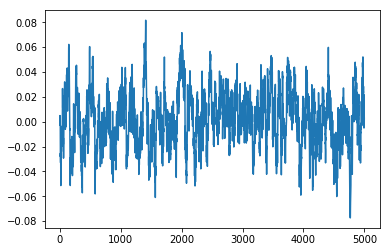

In [2]:
# Let us simulate the technology process
rho = 0.95
sigma = np.sqrt(0.000049)

# Setting up the time periods and the number of states
T = 5000
NS = 21

# Generating random numbers
v = np.random.normal(0, sigma, T)

eta = np.zeros(T+1)
eta[0] = 0

for t in np.arange(T):
    eta[t+1] = rho*eta[t] + v[t]

eta = eta[1:]
    
# Plotting the series
plt.plot(eta)
plt.show()

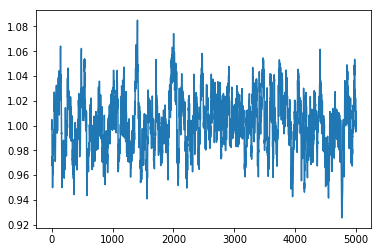

In [3]:
# Transforming the series into levels
A = np.exp(eta)

# Plotting A
plt.plot(A)
plt.show()

We now discretize the series using the Rouwenhorst (1995) algorithm.

In [4]:
# Discretization using Rouwenhorst (1995)

def rouwen(rho, mu, sigma, num):
    
    '''
    Function Rouwen based on Rouwenhorst (1995)
    
    Purpose:    Construct transition probability matrix for discretizing an
                AR(1) y_t = rho y_(t-1) + eps_t process.
                
    Format:     {dscSp, transP} = rouwen(rho, mu, sigma, num)

    Inputs:
                rho: persistence (close to one)
                mu: mean and the middle point of the discrete state space]
                sigma: unconditional std.dev of the process y_t
                num: number of grid points on the discretized process

    Output:
                dscSp: discrete state space (num by 1 vector)
                transP: transition probability matrix over the grid
    '''

    dscSp = np.linspace(-(num-1)**(1/2)*sigma, (num-1)**(1/2)*sigma, num).T

    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T

    while transP.shape[0] <= num - 1:

        len_P = transP.shape[0]
        transP = p*np.vstack((np.hstack((transP,np.zeros((len_P,1)))), np.zeros((1, len_P+1)))) \
        + (1-p)*np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
        + (1-q)*np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
        + q*np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.

    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return dscSp, transP

We can use a simulation function to replicate the original function. The function below simulates a descritized version of the continuous technology process, as defined above.

In [5]:
def mcsim(states, transM, num_sim, start, draw, mu, sigma):
    '''
    Function to simulate a discretizised Markow-Chain-Process
    
    Purpose:    Using the generated estimation for the Markow-Chain,
                simulate a series, which mimics the behavior of the series.
                
    Format:     {sim} = simdiscmc(states, transM, num_sim)
    
    Inputs:     states  = Matrix with the states, generated by tauchen or rouwen
                transM  = Transition matrix from of the same functions
                num_sim = length of the series to simulate
                start   = starting state for the simulation of the Markow-Chain
                draw    = errors from the original series
                mu      = unconditional mean of the error
                sigma   = standard deviation of the error
                
    Output:     chain   = descretizised series of simulated values
    '''
    r = transM.shape[0]
    X = np.zeros((num_sim,1))
    X = st.norm.cdf(draw, loc = mu, scale = sigma)
    s = np.zeros((r,1))
    state = np.zeros((r,num_sim))
    s[start-1,0] = 1
    m = np.ones((transM.shape[0],transM.shape[0]))
    cum = np.dot(transM, np.triu(m))
    temp = np.zeros((1,2))
    for i in range(X.shape[0]):
        state[:,i] = s[:,0]
        temp = np.dot(np.transpose(s),cum)
        ppi = np.zeros([1,1])
        ppi = np.hstack((ppi, temp))
        a = (ppi[0,1:r+1] > X[i])
        b = (X[i] > ppi[0,0:r])
        s1 = np.array(np.transpose(np.multiply(a, b)))
        for j in range(r):
            s[j,0] = s1[j]
    chain = np.dot(np.transpose(states), state)
    return chain

Doing this now for the series above:

In [6]:
# Extracting the states and the transition probabilites
s, pi = rouwen(rho, 0, (sigma**2/(1-rho**2))**(1/2), NS)

# Extracting the simulated series for technology
etasim = mcsim(s, pi, T, int(np.round((NS)/2)), v, 0, sigma)
Asim = np.exp(etasim)

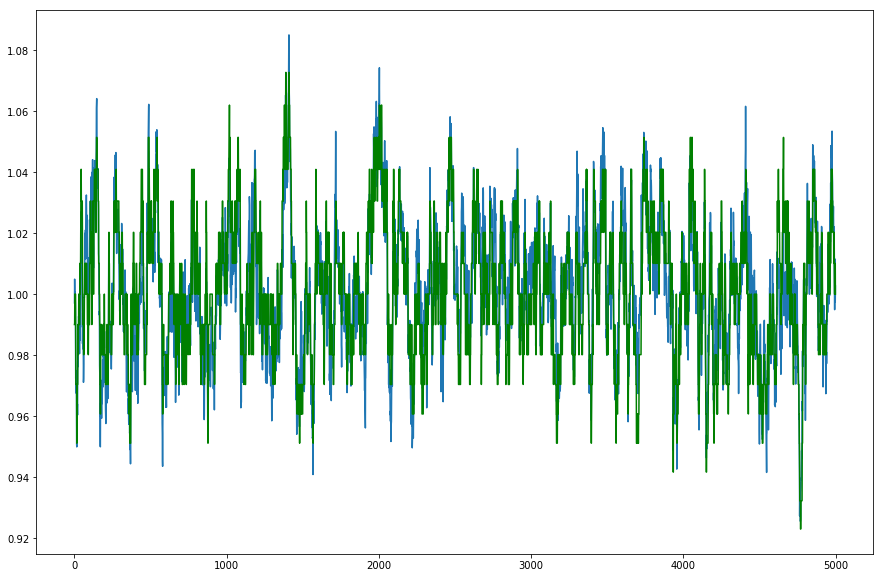

In [7]:
# Plotting
plt.figure(figsize = (15,10))
plt.plot(np.arange(T), A)
plt.plot(np.arange(T), Asim, color = 'green')
plt.show()

The simulated descritized series mimics well the real series. Consequently, we will use the series below for the dynamic programming.

In [8]:
# Setting up the values for the model
parameters = np.zeros(5)
parameters[0] = 0.4         # Alpha
parameters[1] = 0.99        # Beta
parameters[2] = 0.5         # Gamma
parameters[3] = 0.019       # Delta

# Printing the kss for setting up the grids sensible
kss = (parameters[0]*parameters[1]/(1-parameters[1]*(1-parameters[3])))**(1/(1-parameters[0]))
print("The steady state value for capital is %F." % kss)

# Setting up the values for the grid
kmin = 75
kmax = 115
knum = 250

if kss > kmax or kss < kmin:
    sys.exit("The grid must contain the steady state. Adapt kmax and kmin accordingly.")
elif kmax < 1.2*kss:
    sys.exit("The grid must contain the 1.2 times the steady state. Adapt kmax accordingly.")


The steady state value for capital is 78.871460.


In [9]:
# Create a grid for capital

def initialize(start, end, n, guess = 0):
    """Function initializing the capital grid and an initial guess for the value function
    
    Inputs:
    start         = start value for the capital grid
    end           = end point for the capital grid
    n             = number of grid points for the grid
    guess         = Initial guess for the value function
    
    
    Outputs:
    capital       = discretized capital grid
    value         = initial guess for the value function"""
    
    
    capital = np.linspace(start, end, n)
    value = np.ones((n,))*guess
    
    return capital, value


# Testing areas
capital, value = initialize(kmin, kmax, knum)

The policy function iterates on the Euler equation and makes it zero:

$$c(k_i, \eta_j) = \Big[ \beta \sum_{j^+=1}^m \pi_{j,j^+}((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1})c(k_{i^+},\eta_j^+)^{-\frac{1}{\gamma}}\Big]^{-\gamma}$$

In [10]:
# Generating a matrix which relates the two state variables
sbar, kbar = np.meshgrid(s, capital)   

# Initial guess for the policy function
guess = np.exp(sbar)*kbar**parameters[0] - parameters[3]*kbar # Guessing the initial level to be the steady state level

Test for the interpolation!

In [11]:
f = sp.interpolate.interp2d(sbar, kbar, guess, kind = 'quintic')

xnew = s
ynew = capital
znew = f(xnew, ynew)

C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=5,5 nx,ny=33,43 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


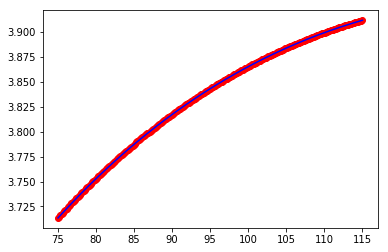

In [12]:
plt.plot(capital, guess[:, 1], 'ro-', ynew, znew[:, 1], 'b-')
plt.show()

In [13]:
from scipy.interpolate import Rbf

rbfi = Rbf(sbar, kbar, guess)  # radial basis function interpolator instance
di = rbfi(sbar, kbar)   # interpolated values

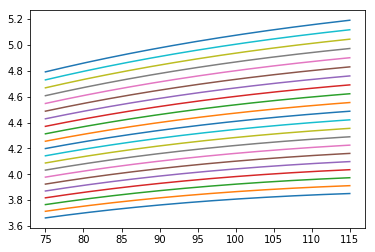

In [14]:
plt.plot(capital, di)
plt.show()

In [15]:
# Generating a cross-related net of the states and capital
sbar, kbar = np.meshgrid(s, capital)
    
# Interpolating over the policy function, but this time into two dimensions
f = sp.interpolate.interp2d(sbar, kbar, guess, kind = 'cubic')

C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=29,63 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


We had so far the first order condition:

$$c(k_i, \eta_j) - \Big[ \beta \sum_{j^+=1}^m \pi_{j,j^+}\big((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1}\big)c(k_{i^+},\eta_j^+)^{-\frac{1}{\gamma}}\Big]^{-\gamma} $$

We now use the budget constraint $c = (1-\delta)k_{i} + k_{i}^\alpha - k_{i^+}$ in both periods and the guess for the policy function $S(k_{i^+},\eta_{j^+})$

$$
(1-\delta)k_i + \exp(\eta_j)k_i^\alpha - k_{i^+} - \Big[ \beta \sum_{i^+=1}^m \pi_{i,i^+}\big((1-\delta)+\alpha \exp(\eta_{j^+}) k_{i^+}^{\alpha-1}\big)S(k_{i^+},\eta_{j^+})^{-\frac{1}{\gamma}}\Big]^{-\gamma} $$

We can transform this equation now with the generated weight above:

$$
(1-\delta)k_i + \exp(\eta_j)k_i^\alpha - k_{i^+} - \Big[ \beta \sum_{i^+=1}^m \hat{\pi}_{i,i^+,j}S(k_{j^+},\eta_{j^+})^{-\frac{1}{\gamma}}\Big]^{-\gamma} $$

In [16]:
def euler(cap, state, guess, capital, states, parameters):
    """Function giving back the exact value for future capital which solves the first order condition
    
    Inputs:
    
    cap         =      value for capital for which the euler equation is evaluated
    state       =      current index of the state variable technology
    guess       =      guess for the policy function in form of an interpolated function
    capital     =      matrix for capital, used in the interpolation
    states      =      matrix of the possible values that capital can take
    parameters  =      Parameters given for the problem
    
    
    Output:
    
    loc     =      value for future capital which solves the euler equation
    
    """
    
    alpha = parameters[0]
    beta = parameters[1]
    gamma = parameters[2]
    delta = parameters[3]
    kss = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
    
    # Define consumption tomorrow as a function of capital tomorrow and technology tomorrow
    cont = lambda cap1, eta1: guess(cap1, eta1)
    
    # Calculate the interest rate at a certain point
    interest = lambda cap1, eta1: (1-delta)+alpha*np.exp(eta1)*cap1**(alpha-1) 
    
    # Get the sum of the marginal utilites (SMU)
    NS = np.shape(states)[0]
    SMU = 0
    for j in np.arange(NS):
        SMU = SMU + pi[state,j]*interest(capital,states[j])*cont(capital, states[j])**(-1/gamma)
    
    # We need to interpolate the function with respect to capital, again
    tck = interp.splrep(capital, SMU, k = 3)
    y_app_spl = lambda x: interp.splev(x, tck)
    
    # Defining consumption today as a function of cap1
    con = lambda cap1: (1-delta)*cap + np.exp(states[state])*cap**alpha - cap1
    
    # Evaluating the residual as a function of future capital
    res = lambda cap1: con(cap1) - (beta*y_app_spl(cap1))**(-gamma)
    loc = opt.fsolve(res, kss)        # We use kss here, since this makes the optimization stable
    return loc


# Testing area
alpha = parameters[0]
beta = parameters[1]
gamma = parameters[2]
delta = parameters[3]
kss = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
loc = euler(kss, 1, f, capital, s, parameters)
print(loc)

[77.81898059]


#### Actual policy function iteration

In [17]:
# Policy function iteration
def pfi(capital, states, guess, parameters):
    """Define the function"""
    
    start = time.time()
    new = np.zeros((knum,NS))
    iteration = 0
    error = 1
    while error > 0.0001 and iteration < 50:
        iteration += 1
        
        # Interpolating over the policy function, but this time into two dimensions
        sbar, kbar = np.meshgrid(states, capital)
        guess1 = sp.interpolate.interp2d(sbar, kbar, guess, kind = 'cubic')
        
        # Until convergence, generate a new policy function based on the current capital stock and the euler solution
        for index1, k in enumerate(capital):
            for index2, s in enumerate(states): 
                # Generate a new policy function
                new[index1,index2] = np.exp(s)*k**parameters[0] - euler(k, index2, guess1, capital, states, parameters) + (1-parameters[3])*k
    
        # Calculating the error
        error = np.absolute(np.max((new - guess)/guess))
    
        # Updating the policy function which is employed in the next iteration round
        guess = np.copy(new)
        print("\n Iteration %1.F, with an error of %F" % (iteration, error))
    
    end = time.time()

    print("\nPolicy function iteration took %1.F iterations, and took %f seconds." % (iteration, end - start))
    return guess

# Testing area
guess = pfi(capital, s, guess, parameters)


 Iteration 1, with an error of 0.309446


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=28,61 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 2, with an error of 0.001918


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=28,60 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 3, with an error of 0.001917


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=28,63 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 4, with an error of 0.001915


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=28,62 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 5, with an error of 0.001914

 Iteration 6, with an error of 0.001913

 Iteration 7, with an error of 0.001912


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=28,64 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 8, with an error of 0.001911

 Iteration 9, with an error of 0.001909

 Iteration 10, with an error of 0.001908


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=29,62 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 11, with an error of 0.001907


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=29,65 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 12, with an error of 0.001906

 Iteration 13, with an error of 0.001905

 Iteration 14, with an error of 0.001904

 Iteration 15, with an error of 0.001902

 Iteration 16, with an error of 0.001901

 Iteration 17, with an error of 0.001900

 Iteration 18, with an error of 0.001899

 Iteration 19, with an error of 0.001898

 Iteration 20, with an error of 0.001897

 Iteration 21, with an error of 0.001896

 Iteration 22, with an error of 0.001895

 Iteration 23, with an error of 0.001893

 Iteration 24, with an error of 0.001892

 Iteration 25, with an error of 0.001891

 Iteration 26, with an error of 0.001890

 Iteration 27, with an error of 0.001889

 Iteration 28, with an error of 0.001888

 Iteration 29, with an error of 0.001887

 Iteration 30, with an error of 0.001886

 Iteration 31, with an error of 0.001885


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=29,64 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 32, with an error of 0.001883

 Iteration 33, with an error of 0.001882

 Iteration 34, with an error of 0.001881


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=29,64 m=5250 fp=0.000027 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 35, with an error of 0.001880

 Iteration 36, with an error of 0.001879


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=29,72 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 37, with an error of 0.001878


C:\Users\User\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=28,65 m=5250 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



 Iteration 38, with an error of 0.001877

 Iteration 39, with an error of 0.001876

 Iteration 40, with an error of 0.001875

 Iteration 41, with an error of 0.001874

 Iteration 42, with an error of 0.001873

 Iteration 43, with an error of 0.001872

 Iteration 44, with an error of 0.001870

 Iteration 45, with an error of 0.001869

 Iteration 46, with an error of 0.001868

 Iteration 47, with an error of 0.001867

 Iteration 48, with an error of 0.001866

 Iteration 49, with an error of 0.001865

 Iteration 50, with an error of 0.001864

Policy function iteration took 50 iterations, and took 692.722797 seconds.


Let's extract the policy function for capital.

In [18]:
# Guess is the policy function for consumption, now we need to extract the policy function for capital
policy = np.exp(sbar)*kbar**alpha - guess + (1-delta)*kbar

# Printing the policy function for consumption
print(policy[-10:])

[[113.01791334 113.07885472 113.14040952 113.2025839  113.2653841
  113.32881642 113.39288721 113.45760289 113.52296997 113.58899498
  113.65568455 113.72304536 113.79108417 113.8598078  113.92922313
  113.99933713 114.07015682 114.1416893  114.21394175 114.2869214
  114.36063557]
 [113.17886073 113.239836   113.30142502 113.36363398 113.4264691
  113.48993669 113.55404311 113.61879478 113.68419821 113.75025994
  113.8169866  113.88438488 113.95246154 114.02122339 114.09067734
  114.16083034 114.23168942 114.3032617  114.37555435 114.4485746
  114.52232979]
 [113.33980534 113.40081446 113.46243768 113.52468118 113.58755119
  113.65105402 113.71519604 113.77998368 113.84542343 113.91152185
  113.97828557 114.04572129 114.11383576 114.1826358  114.25212833
  114.3223203  114.39321876 114.4648308  114.53716361 114.61022443
  114.6840206 ]
 [113.50074716 113.56179011 113.6234475  113.68572551 113.74863039
  113.81216843 113.87634603 113.94116959 114.00664563 114.07278072
  114.13958147 114

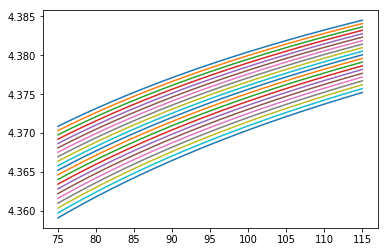

In [19]:
# Plot of the policy function with respect to consumption
plt.plot(capital, guess)
plt.show()

Having the policy function, we now can plot it.

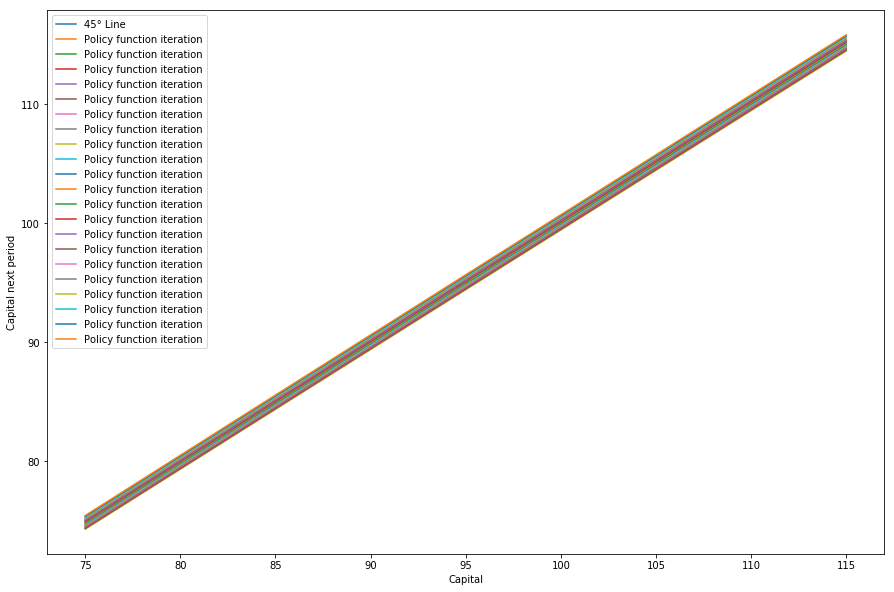

In [20]:
# Plotting the VFI, exact solution, and the policy function iteration solution
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, capital, label = "45° Line")
ax.plot(capital, policy, label = "Policy function iteration")
ax.set_xlabel("Capital")
ax.set_ylabel("Capital next period")
ax.legend(loc = 2)
plt.show()

Next let's find the steady state. We do this by finding the root of an excess function:

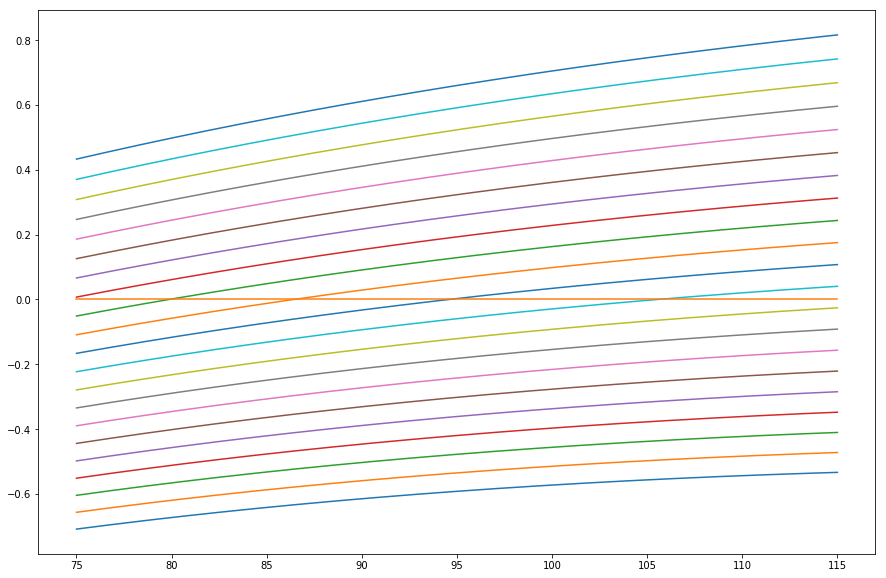

In [21]:
# To check, whether both generate the same steady state we find the root of the excess function:
def excess(pol, cap):
    ex = pol - cap
    return ex

# Generate the excess function
excess = excess(policy,kbar)

# Plot the excess function
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, excess, label = "Excess function")
ax.plot(capital, np.zeros(knum,))
plt.show()

In [22]:
# Let's find the root
tck = interp.splrep(capital, excess[:,int(np.round((NS)/2))])
conexcess = lambda x: interp.splev(x, tck)

# Find the root
loc = opt.fsolve(conexcess, kss)
print("The numerical steady state of the model is %F, while the true steady state is %F" % (loc, kss))

The numerical steady state of the model is 94.621235, while the true steady state is 78.871460


Since we are rather satistfied with the precision, we now can simulate the economy.

In [23]:
# Defining a function to simulate different trajectories
def simulate(k0, T, policy, guess):
    """Description of the function"""
    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, policy)
    polcap = lambda x: interp.splev(x, tck)

    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, guess)
    polcon = lambda x: interp.splev(x, tck)

    
    # Setting up the arrays holding the time series of the simulated economy
    consumption = np.zeros(T)
    investment = np.zeros(T)
    output = np.zeros(T)
    capital1 = np.zeros(T+1)
    capital1[0] = k0

    for t in np.arange(0,T):
        consumption[t] = polcon(capital1[t])
        output[t] = capital1[t]**alpha
        investment[t] = output[t] - consumption[t]
        capital1[t+1] = investment[t] + (1-delta)*capital1[t]
    
    return consumption, investment, output, capital1

# Simulating the time series behavior
con1, inv1, out1, cap1 = simulate(0.1*kss, T, policy, guess)
con2, inv2, out2, cap2 = simulate(1.2*kss, T, policy, guess)

ValueError: too many axes: 2 (effrank=2), expected rank=1


Using the simulated behavior, we now can plot the development of different economies with different initial states.

In [ ]:
# Defining a time sequence and a vector with the kss
time = np.arange(0,T)
vkss = np.zeros(T)
vkss[:] = kss

# Plot the excess function
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))
axes[0,0].plot(time, cap1[0:T])
axes[0,0].plot(time, vkss, label = "Steady-State")
axes[0,0].set_title("Trajectory of capital")
axes[0,0].set_xlabel("Period")
axes[0,0].set_ylabel("Capital")

axes[0,1].plot(time, out1, label = "Output")
axes[0,1].plot(time, con1, label = "Consumption")
axes[0,1].plot(time, inv1, label = "Investment")
axes[0,1].set_title("GDP components")
axes[0,1].set_xlabel("Period")
axes[0,1].set_ylabel("GDP components")
axes[0,1].legend(loc=5)

axes[1,0].plot(time, cap2[0:T])
axes[1,0].set_title("Trajectory of capital")
axes[1,0].plot(time, vkss, label = "Steady-State")
axes[1,0].set_xlabel("Period")
axes[1,0].set_ylabel("Capital")

axes[1,1].plot(time, out2, label = "Output")
axes[1,1].plot(time, con2, label = "Consumption")
axes[1,1].plot(time, inv2, label = "Investment")
axes[1,1].set_title("GDP components")
axes[1,1].set_xlabel("Period")
axes[1,1].set_ylabel("GDP components")
axes[1,1].legend(loc=5)

plt.show()

Let's plot the phase diagram, showing the saddle path for the economy to transit to the steady state. The phase diagram shows the convergence path of the economy, and the function of values for which consumption and capital are constant. Consumption is constant, when capital is at it's steady state value. However, capital is constant, if the difference in capital between periods, is zero.

$$k_{t+1} = (1-\delta)k_t + i_t \\
k_{t+1} - k_t = i_t - \delta k_t \\
0 = i_t - \delta k_t \\
i_t = \delta k_t \\
y_t - c_t = \delta k_t \\
c_t = y_t - \delta k_t$$

In [ ]:
# Setting up some arrays
vkss = np.zeros(knum)
vkss[:] = kss              # Array for the value where consumption is constant
css = policy**alpha - delta*policy

# Plotting the phase diagram
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(policy, guess, label = "Saddle path")
ax.plot(vkss, guess, label = r"$\Delta c = 0$")
ax.plot(policy, css, label = r"$\Delta k = 0$")
ax.legend(loc=2)
plt.show()

The graph looks a bit different from what we know from the books. This is since the books as well portray the situation, where we have a capital stock so high, that all output is going into investment. To achieve this, we need to have:

$$c_t = 0 \\
y_t = \delta k_t \\
k_t^{\alpha} = \delta k_t \\
k_t^{\alpha} - \delta k_t = 0$$

Let's find how big $k_t$ needs to be for this to happen. We know that one solution to this equation would be $k_t = 0$, but we actually exclude this equilibrium, since in such an equilibrium there would not be production. Therefore, we can divide by $k_t$:

$$k_t^{\alpha-1} = \delta \\
k_t = \delta^{\frac{1}{\alpha-1}}$$

In [ ]:
# As derived from theory
loc1 = delta**(1/(alpha-1))

# Define the function
concave = lambda k: k**alpha - delta*k
loc2 = opt.fsolve(concave, 700)
print("The numerical value is %F, while the theoretical value is %F." % (loc1, loc2))

Since this number is very high, we do not continue here to show the whole phase diagram.

### Euler equation residual

THe euler equation residual is a way to compute the error we have in our approximation with the policy function.

$$EER(k) = S(k_t) - [\beta((1-\delta)+\alpha(k_{t+1})^{\alpha-1})]^{-\gamma}S(k_{t+1}) \\
\textrm{with } k_{t+1} = (1-\delta)k_t + k_t^\alpha - S(k_t)$$

Where $S(k_t)$ is the continuous policy function.

In [ ]:
# Interpolating the policy function
tck = interp.splrep(capital, guess)
pol = lambda x: interp.splev(x, tck)

# Using the interpolated policy function to compute the EER
EER = lambda k: pol(k)-((beta*((1-delta)+alpha*((1-delta)*k+k**alpha-pol(k))**(alpha-1)))**(-gamma))*pol((1-delta)*k+k**alpha-pol(k))
EEE = lambda k: (EER(k)/pol(k))

# Setting up the spacing of the grid for which we want to analyze the euler equation error (EEE)
m = (kmax-kmin)/knum

# Setting up the capital grid and calculating the error
k = np.arange(kmin,kmax,m)
error = np.zeros(knum)
for index, cap in enumerate(k):
    error[index] = EEE(cap)

# Plotting the EEE
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(k, error, label = "Euler equation error")
ax.set_xlabel("Current level of capital")
plt.show()

The euler equation error is actually defined as:

$$\max_k |\frac{EER(k)}{S(k)}|$$

It's economic interpretation is as follows: If an agent makes a decision on the allocation of 1000€, using the approximated decision rules, he would make an error of $1000*\max_k |\frac{EER(k)}{S(k)}|$€.

In [ ]:
print("The euler equation error is %F" % np.amax(np.abs(error)))
print("\nThis results in an error for the agent of %F €" % np.amax(np.abs(1000*error)))

As a result, the EEE is really small. This showes that our approximation is rather good.